# CISCO AV Playground

This notebook is an area to explain and explore the provided data file samples from Cisco.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

## Data Files

The data files are as follows:

 - *RL_hits*: 
     Contains the results for scanned files from VirusTotal
 - *RL_info*: 
     Gives statistics on scanning lapse by VT and the SHA256
 - *RL_magic*: 
     Gives the file type
 - *TG_index*: 
     Gives the Cisco features for each file which register a "hit"
 - *TG_map*: 
     Describes the features
 - *TG_submissions*: 
     Gives details on the files scanned by Cisco including SHA256

In [2]:
# Load the data files

RL_hits = pd.read_csv('../data/jan47k/tmp/Jan/RL_hits.csv')
RL_info = pd.read_csv('../data/jan47k/tmp/Jan/RL_info.csv')
RL_magic = pd.read_csv('../data/jan47k/tmp/Jan/RL_magic.csv')

TG_index = pd.read_csv('../data/jan47k/tmp/Jan/TG_ioc_indexed.csv')
TG_map = pd.read_csv('../data/jan47k/tmp/Jan/TG_ioc_map.csv')
TG_submissions = pd.read_csv('../data/jan47k/tmp/Jan/TG_submissions_all.csv')


# Re-process the dates into the correct format
RL_hits['scanned_on'] = RL_hits['scanned_on'].astype(int)
RL_hits['scanned_on'] = pd.to_datetime(RL_hits['scanned_on'], unit='s')

RL_info[['first_scanned_on', 'last_scanned_on']] = RL_info[['first_scanned_on', 'last_scanned_on']].astype(int)
RL_info['first_scanned_on'] = pd.to_datetime(RL_info['first_scanned_on'], unit='s')
RL_info['last_scanned_on'] = pd.to_datetime(RL_info['last_scanned_on'], unit='s')

## Labels

A simple analysis will derive labels using a "$k$ of $n$" approach. The following code combines the `RL` datasets to get this count and also pull in the file type. We also calculate the length of time between first and last submission to VirusTotal. This information gives an indication as to the reliability of the label data; a large lapse will be indicative of a more reliable label.

Deduplication by SHA256 is carried out by dropping all duplicate keys.

In [3]:
# Simple "k of n" analysis: Create a hits column and merge with RL_info. 
# Also pull in the file type and the time between first and last scan
counts = pd.DataFrame(RL_hits.groupby('index')['result'].count())
counts.rename(columns={'result':'hits'}, inplace=True)
RL_new = pd.merge(left=RL_info, right=counts, how='left', left_on='index', right_index=True)

RL_new['hits'].fillna(0, inplace=True)
RL_new = pd.merge(left=RL_new, right=RL_magic, how='left', left_on='index', right_on='index')

RL_new['scan_length'] = (RL_new['last_scanned_on'] - RL_new['first_scanned_on'])  / np.timedelta64(1, 'D')
RL_new.drop_duplicates(subset=['sha256', 'first_scanned_on', 'last_scanned_on', 'sample_size', 'hits', 'sample_type', 'scan_length'], keep='last', inplace=True)
RL_new.head()

index                                             sha256  \
0      1  c26b9b1dfa66611a2d116900f225ee789d16c2314016fe...   
1      3  c261955f613c161c1dd70ef1e225f27edcf3a47ec03c0e...   
2      4  c266de7a8f715183024319fc56fb3b5d26d2646dbac7a6...   
3      5  c2699f0383452ec83ba6cde810f0e5a9e287484896bc9c...   
4      6  c2645bdf03c895e1710d26131538b40df37f262111be01...   

     first_scanned_on     last_scanned_on  sample_size  hits  \
0 2015-12-26 11:01:00 2016-02-02 20:39:00       327440    19   
1 2015-04-10 01:50:00 2016-01-27 17:23:00       327584    23   
2 2016-01-05 15:55:00 2016-01-12 16:04:00       273114     1   
3 2015-12-23 11:28:00 2016-02-01 13:10:00       122368    25   
4 2016-01-06 20:50:00 2016-01-13 22:05:00        25621     0   

                                         sample_type  scan_length  
0  PE32 executable (GUI) Intel 80386, for MS Wind...    38.401389  
1  PE32 executable (GUI) Intel 80386, for MS Windows   292.647917  
2                               Microsoft Word 2007+     7.006250  
3  PE32 executable (GUI) Intel 80386, for MS Windows    40.070833  
4                                               null     7.052083

In [13]:
def assignLabels(df, maxneg=0, minpos=10, duration=0, filterNaNs=True):
    """ Assign labels to a subset based on confidence criteria.
    maxneg specifies the maximum number of positive flags a file can have to be considered not malware (default=0)
    minpos specifies the minimum number of positive flags a file must have to be considered malware (default=10)
    duration is the minimum time lapse between first and last VT scan (default=0)
    """ 
    df['label'] = np.repeat(np.nan, len(df))
    for (index, row) in df.iterrows():
        if row['scan_length'] > duration:
            if row['hits'] <= maxneg:
                df.at[index, 'label'] = 0.0
            elif row['hits'] >= minpos:
                df.at[index, 'label'] = 1.0
    
    if filterNaNs:
        return df.dropna()
    return df

In [15]:
RL_labelled = assignLabels(RL_new, filterNaNs=True)
print(len(RL_new))
print(len(RL_labelled))
print(RL_labelled['label'].sum())
#RL_labelled.head()

44676
38678
19483.0


## Features

With a large set of available features for classification, some pre-processing is required to put the data in a form suitable for machine learning purposes.

Firstly, the `TG_index` data is re-arranged to make each feature its own column with a Boolean value (0 or 1). For data investigation purposes we add a `feature_count` column to the table to count the number of non-zero features.

The `TG_submissions` data is merged in to give the SHA256 values, submission date/time and virtual machine used.

In [4]:
TG_index['value'] = 1
TG_feats = TG_index.pivot(index='submission_id', columns='ioc_index', values='value')
TG_feats.fillna(0, inplace=True)

feat_count = pd.DataFrame(TG_index.groupby('submission_id')['value'].sum())
TG_feats = pd.merge(left=TG_feats, right=feat_count, how='left', left_index=True, right_index=True)
TG_feats.rename(columns={'value':'feature_count'}, inplace=True)

TG_feats = pd.merge(left=TG_feats, right=TG_submissions, how='right', left_index=True, right_on='submission_id')
TG_feats.head()

ioc_index  1  2  3  5  6  10  11  12  15  16  ...    404  405  407  413  \
0          0  0  0  0  0   0   0   0   0   0  ...      0    0    0    1   
1          0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
2          0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
3          0  1  0  0  0   0   0   0   0   0  ...      0    0    0    0   
4          0  1  0  0  0   0   0   0   0   0  ...      0    0    0    0   

ioc_index  feature_count  submission_id          submitted_at  \
0                      1      128161760  2016-01-01T00:00:06Z   
1                      1      128161866  2016-01-01T00:01:13Z   
2                      2      128161876  2016-01-01T00:01:25Z   
3                     23      128161941  2016-01-01T00:02:09Z   
4                     24      128161953  2016-01-01T00:02:21Z   

ioc_index                            sample  \
0          4619e4b6e62676fe2ffe4d76fa4c1361   
1          49ba601b4df48b74c0defee2f11914db   
2          aaebc78fc7ea198aa8bd97d838df5642   
3          f2978e919bf4aa20e0051f54473bfa4c   
4          d9548623a485ce704c381dd92073e4c6   

ioc_index                                             sha256     vm  
0          75620f4216d7f0e5e9dcd76925c23238378d1e0ebc4a41...  winxp  
1          35e0859969ae16d902123e8dbb642041aa8e2858f98854...  winxp  
2          580bee63412854523bf67896c1c6aa3d15329bf71b93ae...  winxp  
3          c868ce36828aba5b2b9a844f4be554b08c076947f72168...  winxp  
4          d89f336a5a1e60e809f7a8e19375b3882e2138d0bba0f6...  winxp  

[5 rows x 282 columns]

In [19]:
# Feature sparsity measure
TG_feats['feature_count'].sum() / (TG_feats['feature_count'].count() * (TG_feats.columns.values.size - 6))

0.01768217949580617

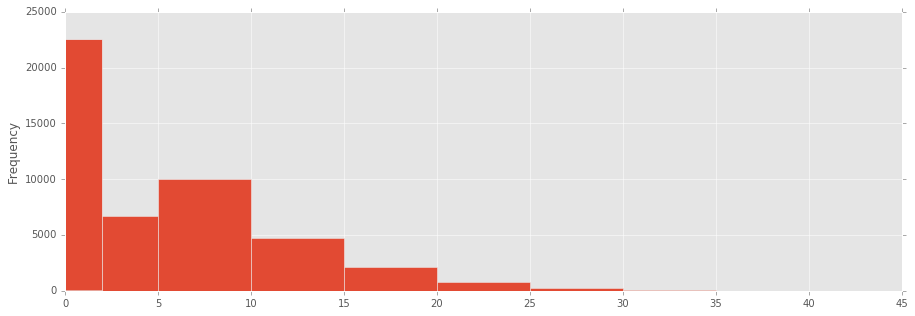

In [23]:
TG_feats['feature_count'].plot(kind='hist', bins=[0,2,5,10,15,20,25,30,35,40,45])

In [81]:
cols = TG_feats.columns.values
mask = ~np.in1d(cols, ['submitted_at','submission_id','sample'])
dup_fields = cols[ix]

TG_dups = TG_feats.drop_duplicates(subset=dup_fields, keep='last')
TG_dups = TG_feats.drop_duplicates(subset='sha256', keep='last')
#TG_dups[TG_dups['sha256'] == '37c82c81e802cbc4c04c8c530378d194d868dc9d8ad2f614e5255636dde9870a']



print(TG_feats.shape)
print(TG_dups.shape)

(47169, 282)
(44676, 282)


In [72]:
a = np.where(RL_new['hits'] == 0)
poss = 0
negs = 0
ambigs = 0
for (index, row) in RL_new.iterrows():
    if row['hits'] == 0:
        negs +=1
    elif row['hits'] >= 10:
        poss += 1
    else:
        ambigs += 1
print(poss)
print(negs)
print(ambigs)

19651
19741
5284


In [44]:
date_diff = (RL_info['last_scanned_on'] - RL_info['first_scanned_on'])  / np.timedelta64(1, 'D')
RL_info['date_diff'] = date_diff
RL_info['date_diff'].plot(kind='hist', bins=[0,7,8,14,21,28,56,84,180,365,730,1800])

In [34]:
RL_info.head()
gb = RL_info.groupby('sha256')
#print(gb.groups)

In [17]:
RL_info[32570:32571]

index                                             sha256  \
32570  34646  81c397808f0463c1ff086a505d0e6e4e657524d395e151...   

         first_scanned_on     last_scanned_on  sample_size  
32570 2016-01-20 00:22:00 2016-01-27 00:30:00        10997

In [72]:
TG_feat[TG_feat['sha256'].str.contains("35ecc3a98611cb2063bce3f0f8ddb566fb82fc24614c377ade1286d3e499014a")]

ioc_index  1  2  3  5  6  10  11  12  15  16  ...    404  405  407  413  \
15081      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15129      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15157      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15172      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15226      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15314      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15325      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15329      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15408      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15444      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15465      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15546      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15593      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15594      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15597      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15599      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15601      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15602      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15603      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15604      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15605      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
15607      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
16365      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
16385      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
16651      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
16855      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
17715      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
18504      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
18621      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
19073      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
19591      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
19988      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   
20857      0  0  0  0  0   0   0   0   0   0  ...      0    0    0    0   

ioc_index  feature_count  submission_id          submitted_at  \
15081                  4      129487737  2016-01-11T13:54:07Z   
15129                  4      129491532  2016-01-11T14:19:09Z   
15157                  4      129494268  2016-01-11T14:36:06Z   
15172                  4      129495276  2016-01-11T14:41:12Z   
15226                  4      129499663  2016-01-11T15:09:56Z   
15314                  4      129508188  2016-01-11T16:05:06Z   
15325                  4      129508895  2016-01-11T16:09:27Z   
15329                  4      129509140  2016-01-11T16:11:24Z   
15408                  4      129515963  2016-01-11T16:51:15Z   
15444                  4      129519198  2016-01-11T17:16:36Z   
15465                  4      129520688  2016-01-11T17:29:32Z   
15546                  4      129528520  2016-01-11T18:32:53Z   
15593                  4      129532727  2016-01-11T19:39:29Z   
15594                  4      129532760  2016-01-11T19:40:16Z   
15597                  4      129532853  2016-01-11T19:43:41Z   
15599                  4      129532905  2016-01-11T19:45:55Z   
15601                  4      129532934  2016-01-11T19:46:10Z   
15602                  4      129532949  2016-01-11T19:46:26Z   
15603                  4      129532971  2016-01-11T19:46:59Z   
15604                  4      129532983  2016-01-11T19:47:41Z   
15605                  4      129533033  2016-01-11T19:49:19Z   
15607              

In [63]:
RL_new['sample_type'].unique()

array([ 'PE32 executable (GUI) Intel 80386, for MS Windows, Nullsoft Installer self-extracting archive',
       'PE32 executable (GUI) Intel 80386, for MS Windows',
       'Microsoft Word 2007+', 'null',
       'PE32 executable (GUI) Intel 80386, for MS Windows, PECompact2 compressed',
       'PE32 executable (GUI) Intel 80386 Mono/.Net assembly, for MS Windows',
       'PE32 executable (DLL) (console) Intel 80386, for MS Windows, UPX compressed',
       'PDF document, version 1.6', 'OLE 2 Compound Document',
       'PE32 executable (console) Intel 80386, for MS Windows',
       'PE32 executable (GUI) Intel 80386, for MS Windows, RAR self-extracting archive',
       'Microsoft Excel 2007+',
       'PE32 executable (DLL) (GUI) Intel 80386, for MS Windows',
       'PE32 executable (GUI) Intel 80386, for MS Windows, UPX compressed',
       'Microsoft Office Document', 'Microsoft OOXML',
       'PE32 executable (console) Intel 80386 (stripped to external PDB), for MS Windows',
       'PE32

In [82]:
RL_new.iloc[44]['sha256']

'c267c3ef0b0c80f9fd990cbb3329f3bf2545b50e27af01d5b5b47ecc72eecc40'

In [77]:
RL_new[RL_new['hits'] == 1]

index                                             sha256  \
2          4  c266de7a8f715183024319fc56fb3b5d26d2646dbac7a6...   
31        34  c263f6f56e3236acf5afef4bdb08b749e28e6873dc1629...   
44        47  c265e1bd57998c8b114df851e323d0b39f85c9784c6a99...   
51        54  c264f7f865b0040e953499f3d2cd51369241cebaf77710...   
69        72  c267ea1ec13716f843858d492e1e96433b8156721f8553...   
74        77  c26a2372cffed5ee86bcbf7131cf1ab0478723f98f67fe...   
84        87  c26f8d03bad69391feab65d26365637655b12bad8bc647...   
95       100  c26e0b585a41dd0841ed01318531e16687074c2f55c85c...   
98       103  c265feca51cff64b993ab5da54ea06197088345dad0649...   
115      121  c26ba59fc2685eeaa254605f8e545d7531f2cb1933cd4d...   
119      125  c2607622c9e7ae561182bb65545564504d5701e27de169...   
133      140  c263729e78291de831fc7fb8848c62d83970351e52610d...   
146      153  c2644c508b58a3c5f9131c6eb135f66b0058e9686bc477...   
148      155  c26e741ccf943b40db4361315f5929fd7d635facc522be...   
151      158  c263a64ea276bfcc289954f6b42eeb2ab5c43edabaedf7...   
156      163  c26e3922203953fa74fc185e3f33fa6dfd6fdb213bc1b7...   
161      168  c26a2697d050c0e7a9464ce3017034da2d92552da26e90...   
171      179  c26cbf19cfc4e23188dbb6ad7816e8a769957ab27d080c...   
191      200  c26e09ad027b8bbe4240f9f9fd83f5cbe39cfd38b998f0...   
242      253  c2625aea39fbdb54db7d0d7305e22a238c5ad9133659c8...   
264      275  c2692c570b67cc0ba0a9ed446b1eb4d8c92908158f99d3...   
268      279  c26d947adee7d560c63bd0ce30a768199706bfdc3ea662...   
299      311  c26cbc503752f9ce869bde78b9e70466528963499bfb84...   
321      334  c2659822c38cebab8c2b96175627289de42b0e55c0acb7...   
326      339  c2612961a2494c2d39f55562b7a44e9762a9a20ea2a5e9...   
328      341  c260099acef49c83b2039e09a59999c7d8b994563e4d41...   
330      344  c26652491d10354bfcf493ff3b85d78945605db378fe70...   
359      373  c26e0940fe3f0f792dcf8e6935222054a8ccd7548787be...   
367      381  c26908b423a45e3b8687914d0bc0bb970dbfe59ba2c56a...   
385      401  c26e9085faf9f764d0749d1c44534f1442d97cf6c5ace6...   
...      ...                                                ...   
46814  49581  5bde1ee27870c2e40897ac6c252ecb13eca12932696058...   
46830  49597  5bd34a448dc5c2ae1ecdf8b0991325485f1e32879029a4...   
46841  49608  5bddcf7181b52c1360fa0f16cb1ec0ca6b991c523637ae...   
46880  49650  5bd319e343aabd4488c063563a757c5646274939eb1f5d...   
46884  49654  5bd998a74c899e3dce7836987ee3d83b48a27a1bb678ec...   
46964  49739  5bd0a03a228320a4ee62e7cc231cea764dcdb3bfadf85a...   
46975  49752  5bd7a6c44e2d3429a407b2246783e6f118a7963a7843b4...   
46980  49757  5bd09a34afc0113522bc9973d2bb590a460a9911967728...   
46987  49764  5bd6a93c5e13871f03175c0b8657ac01bcbe10e3c0965f...   
47016  49793  5bd784f9701ad5e859d8dd520724f59d99710769485e9a...   
47032  49811  5bde2d0534d277f91474314bb9c77c3c537df40d25e498...   
47050  49832  5bd2fd19831f0b9bb8553288bfb2f9bb3f9a28d39db985...   
47063  49845  5bd8c2e739d320b24422f36002591facf155291b3022f3...   
47064  49846  5bdcebf22592e7960c19fb32338723ff7f620d58cc4a9f...   
47068  49850  5bdd2589a5694cfb66542b628be7ad3dc3e35b0e924295...   
47074  49856  5bda13a2861d9eaa9c0a37ed66f421950a5a8cb6d4d944...   
47077  49859  5bd11aeb7c3fde6c058e2333c398c7bd5c13bb8bf4b53b...   
47085  49867  5bdab3a56a925fea8679ddd7f7264c82bc99e305f3adff...   
47109  49892  5bdc862d3e1a93d80a2d8d7f717d9383519bdbfe75434a...   
47112  49895  5bd4036ccf84c7d168e621ef29033e05b847ddc609132d...   
47126  49909  5bd8a0227b864c588fd0dc9b3009dfe7f98d52613000e2...   
47129  49912  5bd1affde051d36e9401165ceda39ac0f9497ccaa10de8...   
47141  49929  5bdcdfba4c3f9fa7ee23387e7bd97cf6d4d2abefe8214a...   
47147  49935  5bde8f4d9ded3ec4661f264cd9bc82c4f087072886ed8f...   
47156  49944  5bd251fb874fd2c757ff4e8f236be1939b98ee9bd0d5fd...   
47160  49948  5bd5dfe2f4f2e724f16956070f643ec86b2e0faba7df9e...   
47166  49954  5bd99d17269d165567f2014dd39abc9ebe575262ac5d03...   
47188  49978  5bd61fa68d11109b219ab83c0ae06a8bb17f10e4

In [80]:
TG_map

index                                        name
0        0                   admin-group-user-addition
1        1                   aedebug-settings-modified
2        2                  antivirus-flagged-artifact
3        3                       antivirus-flagged-cve
4        4                appcertdlls-dll-registration
5        5                      appinit-dll-registered
6        6                       apt-malware-loadmoney
7        7                     apt-malware-nettraveler
8        8                 apt-malware-nettraveler2013
9        9                       apt-malware-onionduke
10      10         artifact-exec-extension-obfuscation
11      11                         artifact-packed-rar
12      12                       autoexec-bat-modified
13      13                      bcdedit-ignore-failure
14      14                broadcast-ipaddress-detected
15      15                   browser-firefox-extension
16      16            browser-helper-object-registered
17      17                       cmd-exe-file-deletion
18      18                      cmd-exe-file-execution
19      19                 command-deleted-shadow-copy
20      20                     crash-dump-file-created
21      21              created-executable-in-user-dir
22      22             currentcontrolset-service-added
23      23                                  decoy-wpfv
24      24           deleted-executable-in-program-dir
25      25            deleted-executable-in-system-dir
26      26                      deleted-submitted-file
27      27                  desktop-wallpaper-modified
28      28            detected-trojan-added-as-service
29      29      disables-security-center-notifications
..     ...                                         ...
384    384              windows-security-center-halted
385    385                          windows-util-assoc
386    386                             windows-util-at
387    387                      windows-util-at-delete
388    388                        windows-util-bcdedit
389    389             windows-util-cacls-everyonefull
390    390               windows-util-cacls-systemnone
391    391                    windows-util-certmgr-add
392    392                   windows-util-certutil-add
393    393                         windows-util-getmac
394    394                       windows-util-mountvol
395    395                        windows-util-net-use
396    396                       windows-util-net-view
397    397                       windows-util-nslookup
398    398                          windows-util-route
399    399                          windows-util-runas
400    400                        windows-util-schtask
401    401                     windows-util-systeminfo
402    402                        windows-util-tracert
403    403  winlogon-notification-package-registration
404    404                             winpcap-dropped
405    405                 winsock-parameters-modified
406    406              wmic-nicconfig-dns-searchorder
407    407                         wmic-process-create
408    408                         wmic-process-delete
409    409                      wmic-product-uninstall
410    410                      wmic-shadowcopy-delete
411    411               wmic-useraccount-never-expire
412    412                     wmic-useraccount-rename
413    413                                         nil

[414 rows x 2 columns]

In [83]:
RL_hits[RL_hits['index'] == 47]

index          scanned_on scanner                   result
381     47 2016-01-28 01:45:00  clamav  PUA.Win32.Packer.Upx-46